### Conduct experiments: impact of water layer depth on (a) transfer function ($T_x$) and (b) DSTL properties
---
* __author__ = Chakraborty, S.
* __copyright__ = 
* __credits__ = []
* __license__ = MIT
* __version__ = 1.0
* __maintainer__ = Chakraborty, S.
* __email__ = shibaji7@vt.edu
* __status__ = Research


> Parameters for this simulation are described in the input control json object 'ICJ' 

In [ ]:
# Import all required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
plt.style.use(["science", "ieee"])
from gic.model.oml import OceanModel
from gic.model.cables import Cable, TheoriticalSolver
from gic.model.utils import RecursiveNamespace, frexp102str
from gic.validation.simulate_synB_synT import SytheticCableAnalysis

from scipy.stats import pearsonr
%matplotlib inline

In [2]:
# Input Control JSON for Qubec Earth model
ICJ = {
    "sid": 1,
    "opcode": 0,
    "Bfield": {
        "structure": { # Describe synthetic B-field structure
            "Am": [ 200, 90, 30, 17, 8, 3.5 ], # Magnitudes of different phase components
            "Tm_min": [ 180, 80, 36, 15, 8, 3 ], # Periods (frequency)) of different phase components
            "Phim": [ 10, 20, 30, 40, 50, 60 ],# Phase (lag/lead) of different phase components
            "T_hours": 72# Time series of B-field length
        },
        "tapering": 0.1 # Tapering coefficient
    },
    "cable": {# Cable description
        "cable_sections": [# Description of cable sections
            {
                "sec_id": None,
                "len_km": 1000,# Length of the cable
                "elec_params": {
                    "earth_model": "FT1", # Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 0,# Ocean depth in meters
                    "ocean_resistivity": 0.3# Ocean resistivity
                }
            }
        ],
        "cable_pot_plot_index": 0
    },
    "out_dir": "tmp/out/001/", # Output directory
    "opname": "Synthetic-B"
}
control = RecursiveNamespace(**ICJ)
resp = []
for d in [10, 100, 1000, 4000]:
    control.cable.cable_sections[0].elec_params.ocean_depth = d
    sca = SytheticCableAnalysis(control.Bfield, control.cable, control.out_dir)
    sca.run()
    resp.append(sca.cable.cable_sections[0].cs_oml)

2022-09-06 14:44:21.927 | INFO     | gic.validation.simulate_synB_synT:__init__:52 - Synthetic B-field run parameters
2022-09-06 14:44:21.927 | INFO     | gic.model.synthetic:__init__:105 - Creating B-field data
2022-09-06 14:44:22.004 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:22.007 | INFO     | gic.validation.simulate_synB_synT:run:98 - Synthetic B FT1->OM(FT1)
2022-09-06 14:44:22.411 | INFO     | gic.validation.simulate_synB_synT:check_analytical_numerical:226 - Corr(Eanl,Enum): 0.9999999961
2022-09-06 14:44:28.188 | INFO     | gic.validation.simulate_synB_synT:__init__:52 - Synthetic B-field run parameters
2022-09-06 14:44:28.189 | INFO     | gic.model.synthetic:__init__:105 - Creating B-field data
2022-09-06 14:44:28.244 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:28.247 | INFO     | gic.validation.simulate_synB_synT:run:98 - Synthetic B FT1->OM(FT1)
2022

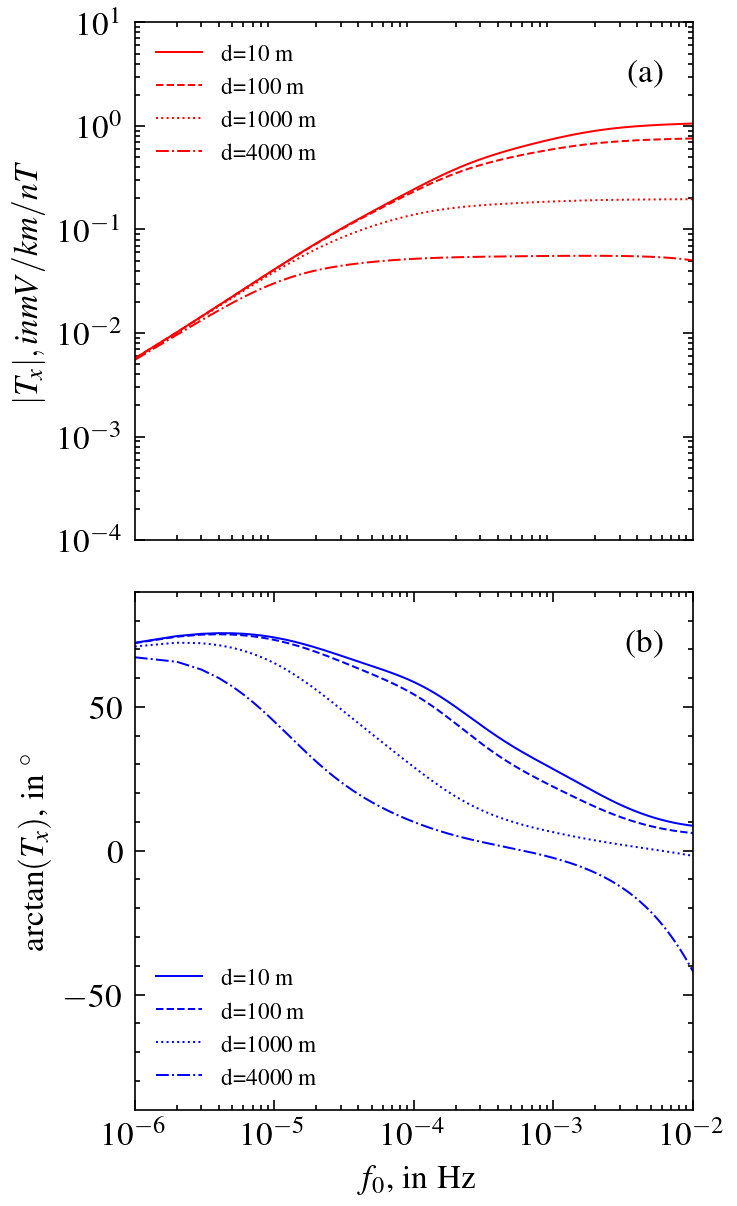

In [3]:
fig = plt.figure(dpi=240, figsize=(3,6))
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
for i, d in enumerate([10, 100, 1000, 4000]):
    Tx = resp[i].get_TFs()
    ax0.loglog(Tx.freq, np.abs(Tx.E2B), "r", lw=0.6, label=r"d=%d m"%d)
    ax1.semilogx(Tx.freq, np.angle(Tx.E2B, deg=True), "b", lw=0.6, label=r"d=%d m"%d)
ax0.text(0.95, 0.9, "(a)", ha="right", va="center", transform=ax0.transAxes)
ax0.set_ylabel(r"$|T_x|$, in mV/km/nT")
ax0.set_xlim(1e-6, 1e-2)
ax0.set_ylim(1e-4, 1e1)
ax0.set_xticks([])
ax0.legend(loc=2, fontsize=7)
ax1.set_xlabel(r"$f_0$, in Hz")
ax1.set_ylabel(r"$\arctan(T_x)$, in $^\circ$")
ax1.set_xlim(1e-6, 1e-2)
ax1.set_ylim(-90, 90)
ax1.legend(loc=3, fontsize=7)
ax1.text(0.95, 0.9, "(b)", ha="right", va="center", transform=ax1.transAxes)
fig.subplots_adjust(hspace=0.1)

In [4]:
e = pd.DataFrame()
e["X"], e["dTime"] = [1], [0] # inputs is in mV/km
Efields = dict(
    syn = e
)
cab = {
    "cable_sections": [
        {
            "sec_id": 0,
            "directed_length": {
                "ln": 10000.
            },
            "elec_params":{
                "earth_model": "FT1",
                "ocean_depth": 4000,
                "ocean_resistivity": 0.3
            }
        }
    ],
    "cable_pot_plot_index": 0
}
Z0, Gma = [], []
D = range(1, 5001, 10)
for t in D:
    cable = RecursiveNamespace(**cab)
    cable.cable_sections[0].elec_params.ocean_depth = t
    txcable = Cable(cable, Efields, None, ["X"], "tmp/out/004/")
    Z0.append(txcable.tx_lines[0].Z0)
    Gma.append(txcable.tx_lines[0].gma)


2022-09-06 14:44:59.354 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.355 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.356 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.358 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 027153b2-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.359 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.361 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.362 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.362 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.364 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02724b96-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:44:59.547 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.549 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.550 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.550 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.553 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 028f0100-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.553 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.555 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.556 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.557 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:5

2022-09-06 14:44:59.639 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 029c358c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.639 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.642 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.643 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.643 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.645 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 029d25b4-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.646 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.648 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.649 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:44:59.730 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.732 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02aa6562-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.732 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.735 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.736 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.736 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.738 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02ab5cba-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.739 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.741 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

2022-09-06 14:44:59.823 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.824 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.826 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02b8b4f0-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.826 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.828 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.829 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.830 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.832 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02b9a4c8-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.832 | INFO     | gic.model.cables:calc_trasmission_line_parameters:

2022-09-06 14:44:59.915 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.916 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.916 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.919 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02c6dae4-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:44:59.919 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:44:59.921 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:44:59.922 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:44:59.922 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:44:59.925 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02c7c832-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:45:00.002 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.004 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.005 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.005 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.008 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02d47938-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.008 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.010 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.011 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.011 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:0

2022-09-06 14:45:00.088 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02e0ce4a-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.089 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.091 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.092 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.092 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.094 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02e1af7c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.095 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.097 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.097 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:45:00.173 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.175 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02edf8ea-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.175 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.177 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.178 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.178 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.180 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02eeda1c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.181 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.183 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

2022-09-06 14:45:00.259 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.259 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.261 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02fb26a0-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.261 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.264 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.264 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.265 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.267 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 02fc0372-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.267 | INFO     | gic.model.cables:calc_trasmission_line_parameters:

2022-09-06 14:45:00.344 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.345 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.345 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.347 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03084a9c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.348 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.350 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.351 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.351 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.353 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03092d86-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:45:00.428 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.431 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.431 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.432 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.434 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03158356-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.434 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.436 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.437 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.437 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:0

2022-09-06 14:45:00.515 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0321dbc4-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.515 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.517 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.518 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.518 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.520 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0322b7a6-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.521 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.523 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.524 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:45:00.600 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.603 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 032f3864-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.603 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.606 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.607 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.607 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.610 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03304858-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.610 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.613 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

2022-09-06 14:45:00.705 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.705 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.708 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 033f475e-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.709 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.711 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.712 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.712 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.715 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 034055cc-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.716 | INFO     | gic.model.cables:calc_trasmission_line_parameters:

2022-09-06 14:45:00.811 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.812 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.812 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.815 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 034f8b50-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.815 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.818 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.819 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.819 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.822 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 035098a6-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:45:00.913 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.916 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.917 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.917 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:00.920 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 035f8dfc-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:00.920 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:00.923 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:00.923 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:00.924 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:0

2022-09-06 14:45:01.019 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 036eaa6c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.019 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.022 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.023 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.023 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.026 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 036fb984-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.026 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.029 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.030 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:45:01.123 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.125 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 037eea12-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.126 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.128 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.129 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.130 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.132 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 037fff4c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.133 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.135 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

2022-09-06 14:45:01.229 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.229 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.232 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 038f367e-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.233 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.236 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.236 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.237 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.240 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 039058c4-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.240 | INFO     | gic.model.cables:calc_trasmission_line_parameters:

2022-09-06 14:45:01.334 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.335 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.335 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.338 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 039f5824-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.338 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.341 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.342 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.342 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.345 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03a063f4-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:45:01.437 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.440 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.441 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.441 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.444 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03af81d6-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.444 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.447 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.447 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.448 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:0

2022-09-06 14:45:01.542 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03be8bcc-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.543 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.546 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.547 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.547 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.550 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03bfaad4-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.550 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.553 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.553 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:45:01.646 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.649 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03cecae6-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.649 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.652 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.653 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.653 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.656 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03cfe886-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.657 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.659 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

2022-09-06 14:45:01.751 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.752 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.754 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03dee502-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.755 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.758 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.758 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.759 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.762 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03dffc58-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.762 | INFO     | gic.model.cables:calc_trasmission_line_parameters:

2022-09-06 14:45:01.851 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.851 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.852 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.854 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03ee3296-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.854 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.857 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.857 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.857 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.860 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03ef104e-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:45:01.935 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.937 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.937 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.938 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:01.940 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 03fb52f0-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:01.940 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:01.942 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:01.943 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:01.944 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:0

2022-09-06 14:45:02.021 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0407a88e-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.021 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.023 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.024 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.024 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.027 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 04088a60-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.027 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.029 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.030 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:45:02.105 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.108 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0414e4ae-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.108 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.110 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.111 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.111 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.113 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0415c9c8-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.114 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.116 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

2022-09-06 14:45:02.192 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.192 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.194 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 04221750-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.194 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.197 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.197 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.198 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.200 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0422f9ae-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.200 | INFO     | gic.model.cables:calc_trasmission_line_parameters:

2022-09-06 14:45:02.277 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.278 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.278 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.281 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 042f4df8-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.281 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.283 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.284 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.284 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.286 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 04302e26-2e14-11ed-af8e-1dafa1160c23 FT1->OM(F

2022-09-06 14:45:02.361 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.364 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.364 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.365 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.367 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 043c7406-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.367 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.369 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.370 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.370 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:0

2022-09-06 14:45:02.447 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0448acda-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.447 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.449 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.450 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.450 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.453 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 04498c22-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.453 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.455 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.456 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length


2022-09-06 14:45:02.531 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.533 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0455d46e-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.534 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.536 | WARNING  | gic.model.cables:setup:398 - Into cable setup section
2022-09-06 14:45:02.536 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-09-06 14:45:02.537 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-06 14:45:02.539 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 0456ba3c-2e14-11ed-af8e-1dafa1160c23 FT1->OM(FT1)
2022-09-06 14:45:02.539 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-09-06 14:45:02.541 | WARNING  | gic.model.cables:setup:398 - Into cable setup sect

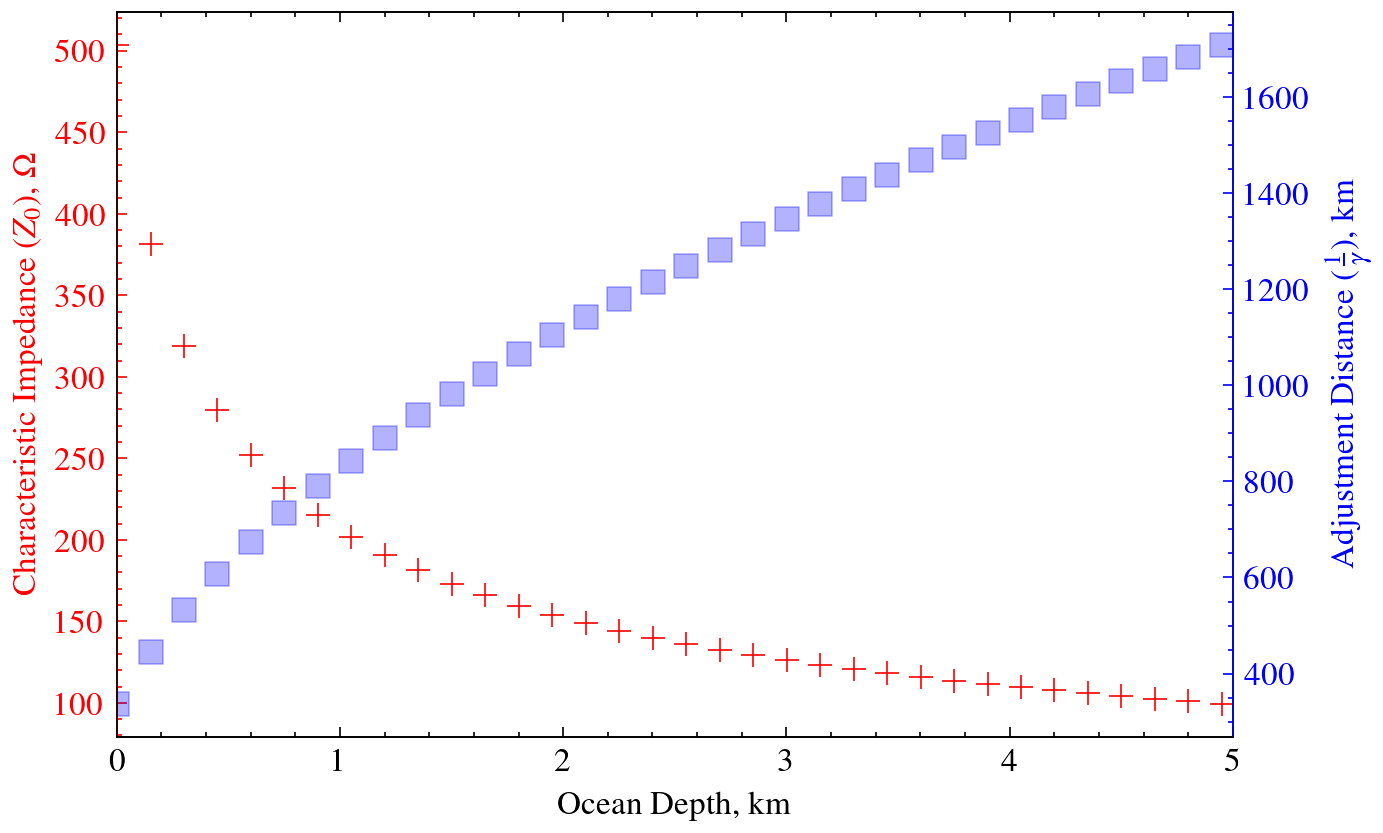

In [5]:
fig = plt.figure(dpi=240, figsize=(6,4))
ax0 = fig.add_subplot(111)
ax0.set_xlabel("Ocean Depth, km")
ax0.set_ylabel(r"Characteristic Impedance ($Z_0$), $\Omega$", color="r")
ax0.spines["left"].set_color("r")
ax0.set_xlim(0,5)
ax0.tick_params(axis="y", colors="r", which="both")
ax0.scatter(np.array(D[::15])/1e3, Z0[::15], marker="+", color="r", ls="None", s=50, linewidth=0.5, zorder=2)
ax0 = ax0.twinx()
ax0.set_ylabel(r"Adjustment Distance ($\frac{1}{\gamma}$), km", color="b")
ax0.scatter(np.array(D[::15])/1e3, 1e-3/np.array(Gma[::15]), marker="s", color="b", 
            ls="None", s=50, linewidth=0.5, zorder=2, alpha=0.3)
ax0.set_xlim(0,5)
ax0.spines["right"].set_color("b")
ax0.tick_params(axis="y", colors="b", which="both")